## Installation Requirements

Before running this notebook, make sure you have the required packages installed. The notebook will attempt to install them automatically, but you can also install them manually:

```bash
pip install torch torchvision torchaudio
pip install torch-geometric
pip install h5py matplotlib seaborn scikit-learn numpy
```

**Note**: If you encounter any installation issues, you may need to restart the kernel after package installation.

# Graph Neural Network Training Pipeline for SPH Physics Simulations

This notebook provides a complete training pipeline for Graph Neural Networks (GNNs) applied to Smoothed Particle Hydrodynamics (SPH) physics simulations. 

## Objectives
- Load SPH dataset from H5 files (5740 particles, 401 timesteps per episode)
- Train a GNN to predict particle dynamics
- Evaluate model performance with comprehensive metrics
- Visualize predictions and training progress

## Dataset Structure
- **Particles**: 5740 particles per timestep
- **Timesteps**: 401 timesteps per episode
- **Features**: 2D positions, particle types (fluid vs boundary)
- **Episodes**: Multiple episodes for training/validation

## Section 1: Import Required Libraries

In [ ]:
# Install required packages
%pip install torch torchvision torchaudio
%pip install torch-geometric
%pip install h5py
%pip install matplotlib seaborn
%pip install scikit-learn
%pip install numpy

print("All packages installed successfully!")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import os
from datetime import datetime
import pickle

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set plot style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        print("Using default matplotlib style")
        
sns.set_palette("husl")

%matplotlib inline

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Available CUDA: {torch.cuda.is_available()}")

Using device: cpu


## Section 2: Load and Explore Dataset

In [5]:
def explore_h5_structure(filepath):
    """Explore the structure of an H5 file to understand what data is available"""
    print(f"Exploring structure of: {os.path.basename(filepath)}")
    print("=" * 60)
    
    with h5py.File(filepath, 'r') as f:
        print(f"Top-level keys: {list(f.keys())}")
        print(f"Number of episodes: {len(list(f.keys()))}")
        
        # Sample first episode
        first_episode = list(f.keys())[0]
        episode_group = f[first_episode]
        print(f"\nEpisode '{first_episode}' structure:")
        
        for key in episode_group.keys():
            dataset = episode_group[key]
            print(f"  {key}: shape={dataset.shape}, dtype={dataset.dtype}")
            
            # Show data range for positions
            if key == 'position':
                data = dataset[:]
                print(f"    Position range: [{data.min():.3f}, {data.max():.3f}]")
            elif key == 'particle_type':
                data = dataset[:]
                unique_types = np.unique(data)
                print(f"    Particle types: {unique_types}")
        print()

# Explore dataset structure
data_dir = '/Volumes/Meida/01-CodeLab/01-personal-project/2D_DAM_5740_20kevery100'
train_path = os.path.join(data_dir, 'train.h5')
valid_path = os.path.join(data_dir, 'valid.h5')
test_path = os.path.join(data_dir, 'test.h5')

for path in [train_path, valid_path, test_path]:
    if os.path.exists(path):
        explore_h5_structure(path)

Exploring structure of: train.h5
Top-level keys: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049']
Number of episodes: 50

Episode '00000' structure:
  particle_type: shape=(5740,), dtype=int64
    Particle types: [0 1]
  position: shape=(401, 5740, 2), dtype=float32
    Position range: [0.050, 5.436]

Exploring structure of: valid.h5
Top-level keys: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024']
Number of episodes: 

In [6]:
def load_h5_dataset(filepath, max_episodes=None, skip_timesteps=1):
    """Load SPH dataset from H5 file with memory optimization
    
    Args:
        filepath: Path to H5 file
        max_episodes: Maximum number of episodes to load (for testing)
        skip_timesteps: Load every N timesteps to reduce memory usage
    
    Returns:
        positions: (episodes, timesteps, particles, 2)
        particle_types: (episodes, particles)
    """
    with h5py.File(filepath, 'r') as f:
        episodes = sorted(list(f.keys()))
        if max_episodes:
            episodes = episodes[:max_episodes]
        
        print(f"Loading {len(episodes)} episodes from {os.path.basename(filepath)}")
        
        all_positions = []
        all_particle_types = []
        
        for i, episode_id in enumerate(episodes):
            if i % 10 == 0:
                print(f"  Loading episode {i+1}/{len(episodes)}...")
                
            # Load position data with optional timestep skipping
            positions = f[f'{episode_id}/position'][::skip_timesteps]
            particle_types = f[f'{episode_id}/particle_type'][:]
            
            all_positions.append(torch.tensor(positions, dtype=torch.float32))
            all_particle_types.append(torch.tensor(particle_types, dtype=torch.long))
            
        # Stack all episodes
        positions = torch.stack(all_positions)
        particle_types = torch.stack(all_particle_types)
        
        print(f"Final shape - Positions: {positions.shape}, Types: {particle_types.shape}")
        return positions, particle_types

# Load datasets with memory considerations
print("Loading training data...")
train_pos, train_types = load_h5_dataset(train_path, max_episodes=10, skip_timesteps=5)

print("\nLoading validation data...")
valid_pos, valid_types = load_h5_dataset(valid_path, max_episodes=3, skip_timesteps=5)

print("\nLoading test data...")
test_pos, test_types = load_h5_dataset(test_path, max_episodes=2, skip_timesteps=5)

Loading training data...
Loading 10 episodes from train.h5
  Loading episode 1/10...
Final shape - Positions: torch.Size([10, 81, 5740, 2]), Types: torch.Size([10, 5740])

Loading validation data...
Loading 3 episodes from valid.h5
  Loading episode 1/3...
Final shape - Positions: torch.Size([10, 81, 5740, 2]), Types: torch.Size([10, 5740])

Loading validation data...
Loading 3 episodes from valid.h5
  Loading episode 1/3...
Final shape - Positions: torch.Size([3, 81, 5740, 2]), Types: torch.Size([3, 5740])

Loading test data...
Loading 2 episodes from test.h5
  Loading episode 1/2...
Final shape - Positions: torch.Size([3, 81, 5740, 2]), Types: torch.Size([3, 5740])

Loading test data...
Loading 2 episodes from test.h5
  Loading episode 1/2...
Final shape - Positions: torch.Size([2, 81, 5740, 2]), Types: torch.Size([2, 5740])
Final shape - Positions: torch.Size([2, 81, 5740, 2]), Types: torch.Size([2, 5740])



Training Analysis:
Position range: [0.050, 5.436]
Unique particle types: tensor([0, 1])
Particle type distribution: [50000, 7400]

Validation Analysis:
Position range: [0.050, 5.436]
Unique particle types: tensor([0, 1])
Particle type distribution: [15000, 2220]

Test Analysis:
Position range: [0.050, 5.436]
Unique particle types: tensor([0, 1])
Particle type distribution: [10000, 1480]


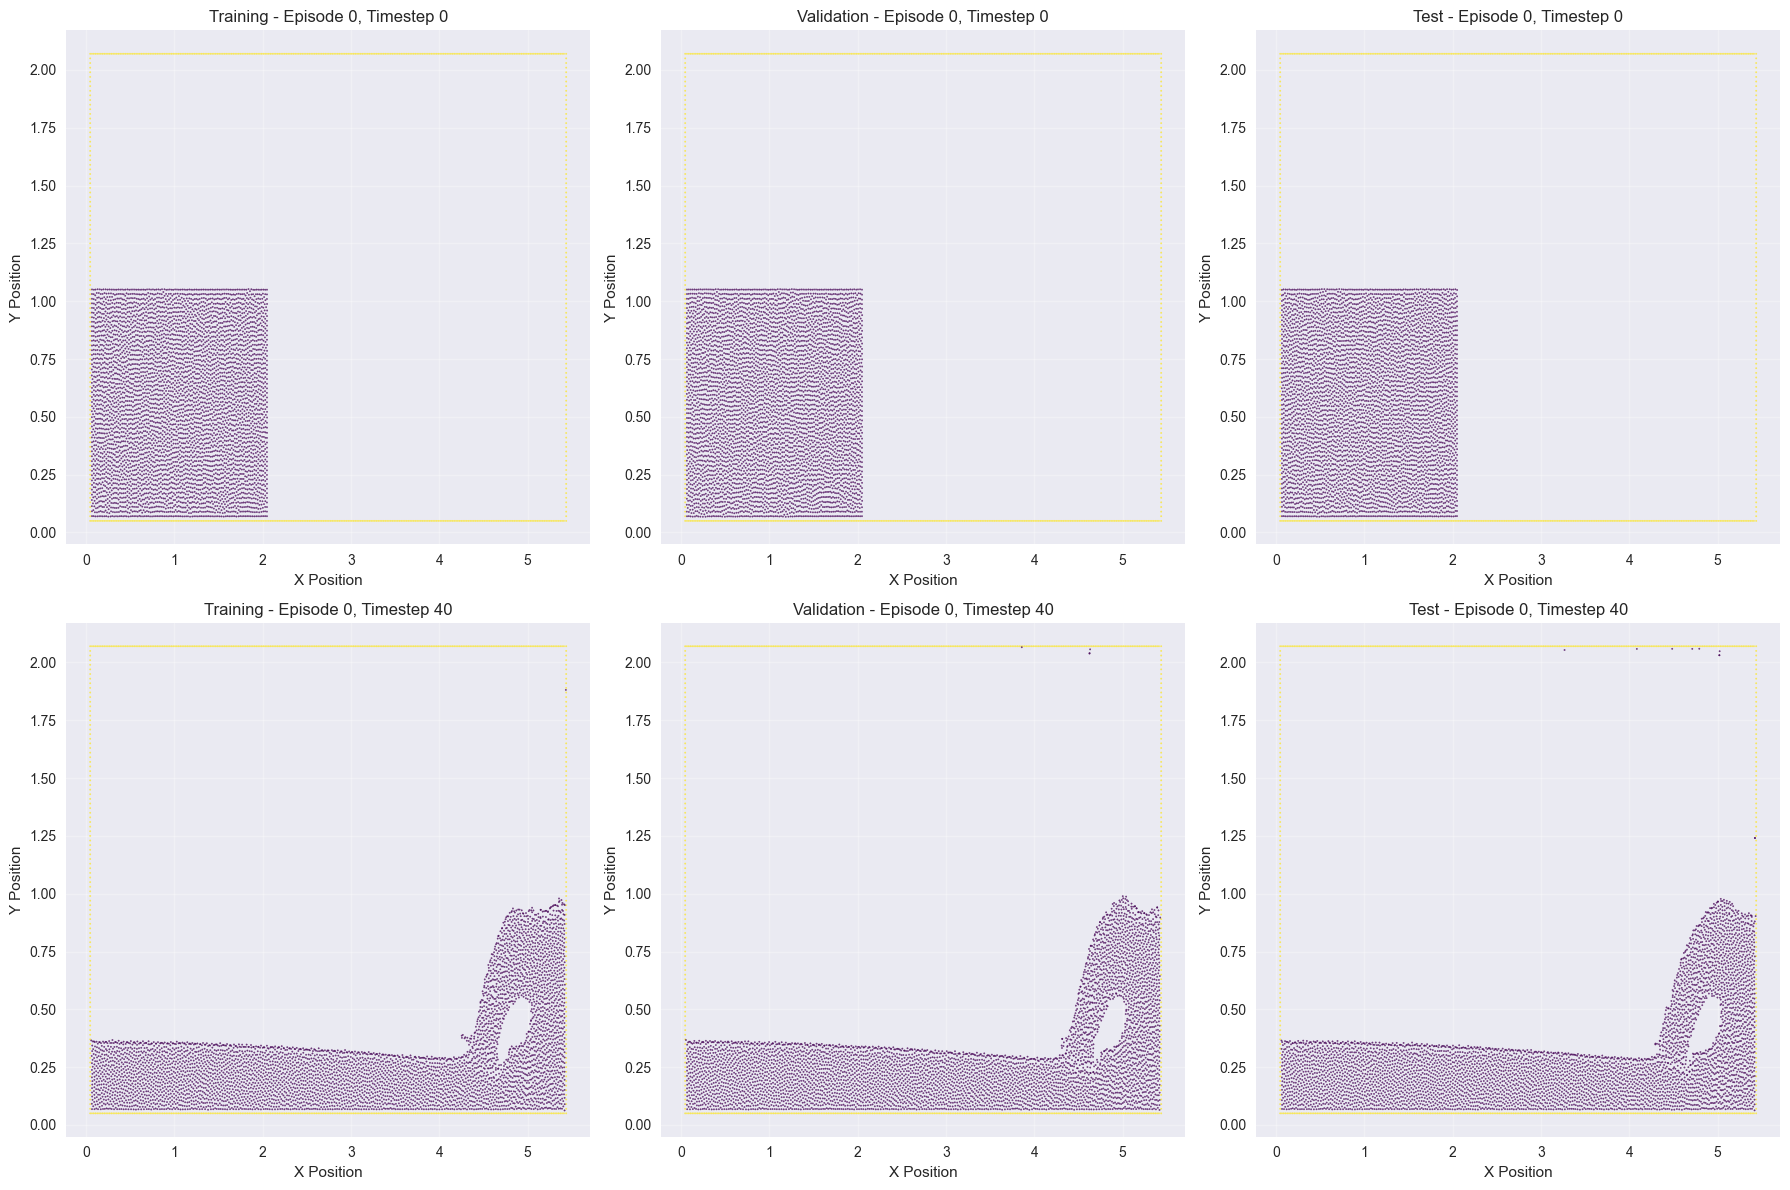

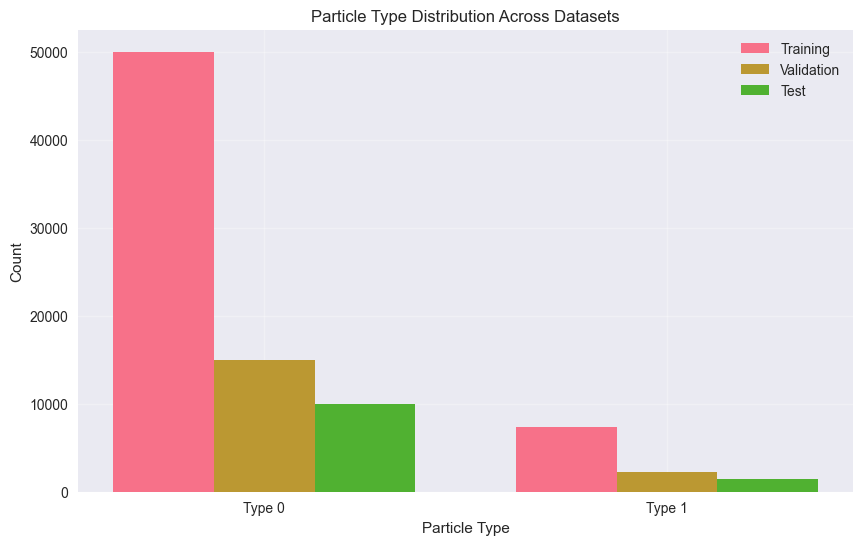

In [7]:
# Dataset statistics and visualization
def analyze_dataset(positions, particle_types, name="Dataset"):
    """Analyze and visualize dataset statistics"""
    print(f"\n{name} Analysis:")
    print(f"Position range: [{positions.min():.3f}, {positions.max():.3f}]")
    print(f"Unique particle types: {torch.unique(particle_types)}")
    
    # Particle type distribution
    type_counts = torch.bincount(particle_types.flatten())
    print(f"Particle type distribution: {type_counts.tolist()}")
    
    return {
        'pos_min': positions.min().item(),
        'pos_max': positions.max().item(),
        'type_counts': type_counts
    }

# Analyze all datasets
train_stats = analyze_dataset(train_pos, train_types, "Training")
valid_stats = analyze_dataset(valid_pos, valid_types, "Validation")
test_stats = analyze_dataset(test_pos, test_types, "Test")

# Visualize sample data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot sample timesteps from different episodes
for i, (pos, types, title) in enumerate([(train_pos, train_types, "Training"),
                                        (valid_pos, valid_types, "Validation"),
                                        (test_pos, test_types, "Test")]):
    # First timestep
    ax1 = axes[0, i]
    sample_pos = pos[0, 0]  # First episode, first timestep
    sample_types = types[0]
    
    scatter = ax1.scatter(sample_pos[:, 0], sample_pos[:, 1], 
                         c=sample_types, s=1, cmap='viridis', alpha=0.7)
    ax1.set_title(f'{title} - Episode 0, Timestep 0')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.grid(True, alpha=0.3)
    
    # Later timestep
    ax2 = axes[1, i]
    mid_timestep = pos.shape[1] // 2
    sample_pos = pos[0, mid_timestep]  # First episode, middle timestep
    
    scatter = ax2.scatter(sample_pos[:, 0], sample_pos[:, 1], 
                         c=sample_types, s=1, cmap='viridis', alpha=0.7)
    ax2.set_title(f'{title} - Episode 0, Timestep {mid_timestep}')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot particle type distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
type_data = {
    'Training': train_stats['type_counts'].numpy(),
    'Validation': valid_stats['type_counts'].numpy(),
    'Test': test_stats['type_counts'].numpy()
}

x = np.arange(len(train_stats['type_counts']))
width = 0.25

for i, (name, counts) in enumerate(type_data.items()):
    ax.bar(x + i*width, counts, width, label=name)

ax.set_xlabel('Particle Type')
ax.set_ylabel('Count')
ax.set_title('Particle Type Distribution Across Datasets')
ax.set_xticks(x + width)
ax.set_xticklabels([f'Type {i}' for i in range(len(x))])
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Section 3: Preprocess Data

In [8]:
def build_neighbor_graph(positions, radius=0.1, max_neighbors=50):
    """Build graph connectivity from particle positions
    
    Args:
        positions: (N, 2) tensor of particle positions
        radius: Maximum distance for particle connections
        max_neighbors: Maximum neighbors per particle (for memory efficiency)
    
    Returns:
        edge_index: (2, E) tensor of edge connections
    """
    n_particles = positions.size(0)
    
    # Compute pairwise distances
    pos_i = positions.unsqueeze(1)  # (N, 1, 2)
    pos_j = positions.unsqueeze(0)  # (1, N, 2)
    distances = torch.norm(pos_i - pos_j, dim=2)  # (N, N)
    
    # Find neighbors within radius (excluding self-connections)
    mask = (distances <= radius) & (distances > 0)
    
    # Optional: Limit number of neighbors per particle
    if max_neighbors is not None:
        for i in range(n_particles):
            neighbor_distances = distances[i]
            neighbor_mask = mask[i]
            
            if neighbor_mask.sum() > max_neighbors:
                # Keep only closest neighbors
                neighbor_distances[~neighbor_mask] = float('inf')
                _, closest_idx = neighbor_distances.topk(max_neighbors, largest=False)
                
                # Reset mask for this particle
                mask[i] = False
                mask[i, closest_idx] = True
    
    # Convert to edge_index format
    edges = torch.nonzero(mask, as_tuple=False)
    edge_index = edges.t().contiguous()
    
    return edge_index

def create_graph_data(positions, particle_types, timestep_idx, target_positions=None):
    """Create PyTorch Geometric Data object from particle data
    
    Args:
        positions: (N, 2) current positions
        particle_types: (N,) particle types
        timestep_idx: Current timestep index
        target_positions: (N, 2) target positions for next timestep
    
    Returns:
        Data object for PyTorch Geometric
    """
    # Node features: [x, y, particle_type_one_hot, timestep_normalized]
    num_types = particle_types.max().item() + 1
    type_one_hot = F.one_hot(particle_types, num_classes=num_types).float()
    
    # Normalize timestep
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
    # Combine features
    x = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    
    # Build graph connectivity
    edge_index = build_neighbor_graph(positions, radius=0.1)
    
    # Create data object
    data = Data(x=x, edge_index=edge_index)
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

def prepare_training_data(positions, particle_types, sequence_length=5):
    """Prepare sequences of graph data for training
    
    Args:
        positions: (episodes, timesteps, particles, 2)
        particle_types: (episodes, particles)
        sequence_length: Number of timesteps to use for prediction
    
    Returns:
        List of Data objects for training
    """
    data_list = []
    
    for episode in range(positions.shape[0]):
        episode_types = particle_types[episode]
        
        for t in range(positions.shape[1] - sequence_length):
            # Current state
            current_pos = positions[episode, t]
            
            # Target (next timestep)
            target_pos = positions[episode, t + 1]
            
            # Create graph data
            data = create_graph_data(current_pos, episode_types, t, target_pos)
            data_list.append(data)
    
    return data_list

# Prepare training data
print("Preparing training data...")
train_data_list = prepare_training_data(train_pos, train_types)
print(f"Created {len(train_data_list)} training samples")

print("Preparing validation data...")
valid_data_list = prepare_training_data(valid_pos, valid_types)
print(f"Created {len(valid_data_list)} validation samples")

print("Preparing test data...")
test_data_list = prepare_training_data(test_pos, test_types)
print(f"Created {len(test_data_list)} test samples")

# Analyze graph statistics
if train_data_list:
    sample_data = train_data_list[0]
    print(f"\nSample graph statistics:")
    print(f"Number of nodes: {sample_data.x.size(0)}")
    print(f"Number of edges: {sample_data.edge_index.size(1)}")
    print(f"Node features: {sample_data.x.size(1)}")
    print(f"Average degree: {2 * sample_data.edge_index.size(1) / sample_data.x.size(0):.2f}")

# Create data loaders
batch_size = 4  # Small batch size due to large graphs
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")

Preparing training data...
Created 760 training samples
Preparing validation data...
Created 228 validation samples
Preparing test data...
Created 152 test samples

Sample graph statistics:
Number of nodes: 5740
Number of edges: 260465
Node features: 5
Average degree: 90.75

Data loaders created:
Training batches: 190
Validation batches: 57
Test batches: 38


/Users/mac/miniconda3/envs/sandbox-ml/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Section 4: Define Model Architecture

In [9]:
class ParticleDynamicsGNN(MessagePassing):
    """Graph Neural Network for predicting particle dynamics in SPH simulations"""
    
    def __init__(self, in_channels, hidden_channels=64, num_layers=3, dropout=0.1):
        super().__init__(aggr='add')
        
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Input embedding
        self.input_embedding = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Message passing layers
        self.message_mlps = nn.ModuleList()
        self.update_mlps = nn.ModuleList()
        
        for _ in range(num_layers):
            # Message MLP
            message_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.message_mlps.append(message_mlp)
            
            # Update MLP
            update_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.update_mlps.append(update_mlp)
        
        # Output layer for position prediction
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, 2)  # Predict 2D position
        )
        
        # Skip connections
        self.skip_connections = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels) for _ in range(num_layers)
        ])
        
    def forward(self, x, edge_index, batch=None):
        # Input embedding
        h = self.input_embedding(x)
        
        # Store for skip connections
        residual = h
        
        # Message passing layers
        for i in range(self.num_layers):
            h_new = self.propagate(edge_index, x=h, layer_idx=i)
            
            # Skip connection
            if i > 0:
                h_new = h_new + self.skip_connections[i](residual)
            
            h = h_new
            
            # Update residual every 2 layers
            if i % 2 == 1:
                residual = h
        
        # Output layer
        out = self.output_layer(h)
        
        return out
    
    def message(self, x_i, x_j, layer_idx):
        # x_i: features of target nodes
        # x_j: features of source nodes
        
        # Concatenate source and target features
        msg_input = torch.cat([x_i, x_j], dim=1)
        
        # Apply message MLP
        msg = self.message_mlps[layer_idx](msg_input)
        
        return msg
    
    def update(self, aggr_out, x, layer_idx):
        # aggr_out: aggregated messages
        # x: current node features
        
        # Concatenate current features with aggregated messages
        update_input = torch.cat([x, aggr_out], dim=1)
        
        # Apply update MLP
        updated = self.update_mlps[layer_idx](update_input)
        
        return updated
    
    def propagate(self, edge_index, x, layer_idx):
        # Custom propagate to pass layer index
        
        # Compute messages
        row, col = edge_index
        x_i = x[row]
        x_j = x[col]
        
        msg = self.message(x_i, x_j, layer_idx)
        
        # Aggregate messages
        aggr_out = torch.zeros_like(x)
        aggr_out.index_add_(0, row, msg)
        
        # Update nodes
        out = self.update(aggr_out, x, layer_idx)
        
        return out

# Initialize model
if train_data_list:
    input_dim = train_data_list[0].x.size(1)
else:
    input_dim = 6  # Default: x, y, particle_type_onehot, timestep

model = ParticleDynamicsGNN(
    in_channels=input_dim,
    hidden_channels=128,
    num_layers=4,
    dropout=0.15
).to(device)

# Model summary
print("Model Architecture:")
print(f"Input dimensions: {input_dim}")
print(f"Hidden dimensions: {model.hidden_channels}")
print(f"Number of layers: {model.num_layers}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test forward pass
if train_data_list:
    model.eval()
    with torch.no_grad():
        sample_batch = next(iter(train_loader))
        sample_batch = sample_batch.to(device)
        output = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
        print(f"\nTest forward pass:")
        print(f"Input shape: {sample_batch.x.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Target shape: {sample_batch.y.shape}")

Model Architecture:
Input dimensions: 5
Hidden dimensions: 128
Number of layers: 4
Total parameters: 470,466
Trainable parameters: 470,466

Test forward pass:
Input shape: torch.Size([22960, 5])
Output shape: torch.Size([22960, 2])
Target shape: torch.Size([22960, 2])

Test forward pass:
Input shape: torch.Size([22960, 5])
Output shape: torch.Size([22960, 2])
Target shape: torch.Size([22960, 2])


## Section 5: Train the Model

In [10]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    total_samples = 0
    
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(pred, batch.y)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * batch.y.size(0)
        total_samples += batch.y.size(0)
        
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return total_loss / total_samples

def validate_epoch(model, valid_loader, criterion, device):
    """Validate model for one epoch"""
    model.eval()
    total_loss = 0
    total_samples = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch in valid_loader:
            batch = batch.to(device)
            
            pred = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(pred, batch.y)
            
            total_loss += loss.item() * batch.y.size(0)
            total_samples += batch.y.size(0)
            
            predictions.append(pred.cpu())
            targets.append(batch.y.cpu())
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # Calculate additional metrics
    mse = F.mse_loss(predictions, targets)
    mae = F.l1_loss(predictions, targets)
    
    return total_loss / total_samples, mse.item(), mae.item(), predictions, targets

# Training configuration
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, verbose=True
)
criterion = nn.MSELoss()

# Training tracking
training_history = {
    'train_loss': [],
    'valid_loss': [],
    'valid_mse': [],
    'valid_mae': [],
    'learning_rates': [],
    'epoch_times': []
}

# Training loop
num_epochs = 30
best_valid_loss = float('inf')
patience = 10
patience_counter = 0

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validation
    valid_loss, valid_mse, valid_mae, val_preds, val_targets = validate_epoch(
        model, valid_loader, criterion, device
    )
    
    # Learning rate scheduling
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Track metrics
    epoch_time = time.time() - epoch_start
    training_history['train_loss'].append(train_loss)
    training_history['valid_loss'].append(valid_loss)
    training_history['valid_mse'].append(valid_mse)
    training_history['valid_mae'].append(valid_mae)
    training_history['learning_rates'].append(current_lr)
    training_history['epoch_times'].append(epoch_time)
    
    print(f"Train Loss: {train_loss:.6f}")
    print(f"Valid Loss: {valid_loss:.6f}")
    print(f"Valid MSE: {valid_mse:.6f}")
    print(f"Valid MAE: {valid_mae:.6f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'training_history': training_history
        }, 'best_gnn_model.pth')
        print("★ New best model saved!")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("\nEarly stopping triggered!")
            break

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time:.2f}s")
print(f"Best validation loss: {best_valid_loss:.6f}")

/Users/mac/miniconda3/envs/sandbox-ml/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...

Epoch 1/30
--------------------------------------------------
  Batch 0/190, Loss: 7.793872
  Batch 0/190, Loss: 7.793872
  Batch 10/190, Loss: 1.157490
  Batch 10/190, Loss: 1.157490
  Batch 20/190, Loss: 0.534790
  Batch 20/190, Loss: 0.534790
  Batch 30/190, Loss: 0.269104
  Batch 30/190, Loss: 0.269104
  Batch 40/190, Loss: 0.153750
  Batch 40/190, Loss: 0.153750
  Batch 50/190, Loss: 0.128723
  Batch 50/190, Loss: 0.128723
  Batch 60/190, Loss: 0.106395
  Batch 60/190, Loss: 0.106395
  Batch 70/190, Loss: 0.064613
  Batch 70/190, Loss: 0.064613
  Batch 80/190, Loss: 0.070185
  Batch 80/190, Loss: 0.070185


KeyboardInterrupt: 

## Section 6: Evaluate Training Performance

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Loss curves
ax1 = axes[0, 0]
epochs = range(1, len(training_history['train_loss']) + 1)
ax1.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, training_history['valid_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# MSE and MAE
ax2 = axes[0, 1]
ax2.plot(epochs, training_history['valid_mse'], 'g-', label='MSE', linewidth=2)
ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, training_history['valid_mae'], 'orange', label='MAE', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE', color='g')
ax2_twin.set_ylabel('MAE', color='orange')
ax2.set_title('Validation MSE and MAE')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Learning rate
ax3 = axes[0, 2]
ax3.plot(epochs, training_history['learning_rates'], 'purple', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Epoch times
ax4 = axes[1, 0]
ax4.plot(epochs, training_history['epoch_times'], 'brown', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Time (seconds)')
ax4.set_title('Training Time per Epoch')
ax4.grid(True, alpha=0.3)

# Loss improvement
ax5 = axes[1, 1]
train_improvement = np.array(training_history['train_loss'])
valid_improvement = np.array(training_history['valid_loss'])
train_improvement = (train_improvement[0] - train_improvement) / train_improvement[0] * 100
valid_improvement = (valid_improvement[0] - valid_improvement) / valid_improvement[0] * 100

ax5.plot(epochs, train_improvement, 'b--', label='Training Improvement (%)', linewidth=2)
ax5.plot(epochs, valid_improvement, 'r--', label='Validation Improvement (%)', linewidth=2)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Improvement (%)')
ax5.set_title('Loss Improvement Over Time')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Final metrics summary
ax6 = axes[1, 2]
final_metrics = {
    'Final Train Loss': training_history['train_loss'][-1],
    'Final Valid Loss': training_history['valid_loss'][-1],
    'Best Valid Loss': min(training_history['valid_loss']),
    'Final MSE': training_history['valid_mse'][-1],
    'Final MAE': training_history['valid_mae'][-1]
}

metric_names = list(final_metrics.keys())
metric_values = list(final_metrics.values())

bars = ax6.bar(range(len(metric_names)), metric_values, 
               color=['blue', 'red', 'green', 'orange', 'purple'])
ax6.set_xlabel('Metrics')
ax6.set_ylabel('Value')
ax6.set_title('Final Training Metrics')
ax6.set_xticks(range(len(metric_names)))
ax6.set_xticklabels(metric_names, rotation=45, ha='right')
ax6.set_yscale('log')

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print training summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total epochs trained: {len(training_history['train_loss'])}")
print(f"Best validation loss: {min(training_history['valid_loss']):.6f}")
print(f"Final training loss: {training_history['train_loss'][-1]:.6f}")
print(f"Final validation loss: {training_history['valid_loss'][-1]:.6f}")
print(f"Final MSE: {training_history['valid_mse'][-1]:.6f}")
print(f"Final MAE: {training_history['valid_mae'][-1]:.6f}")
print(f"Total training time: {sum(training_history['epoch_times']):.2f}s")
print(f"Average time per epoch: {np.mean(training_history['epoch_times']):.2f}s")
print("\nModel saved as: best_gnn_model.pth")

## Section 7: Make Predictions

In [ ]:
# Load best model
print("Loading best model...")
checkpoint = torch.load('best_gnn_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['valid_loss']:.6f}")

def predict_sequence(model, initial_data, num_steps, device):
    """Predict a sequence of future timesteps
    
    Args:
        model: Trained GNN model
        initial_data: Initial graph data
        num_steps: Number of future steps to predict
        device: Device to run on
    
    Returns:
        List of predicted positions
    """
    model.eval()
    predictions = []
    current_data = initial_data.clone().to(device)
    
    with torch.no_grad():
        for step in range(num_steps):
            # Predict next position
            pred_pos = model(current_data.x, current_data.edge_index)
            predictions.append(pred_pos.cpu())
            
            # Update current data for next prediction
            # Update positions in features (first 2 dimensions)
            current_data.x[:, :2] = pred_pos
            
            # Rebuild graph with new positions
            current_data.edge_index = build_neighbor_graph(pred_pos.squeeze(), radius=0.1)
            
            # Update timestep feature (if present)
            if current_data.x.size(1) > 4:  # Has timestep feature
                current_data.x[:, -1] += 1.0 / 100.0  # Increment normalized timestep
    
    return predictions

# Make predictions on test set
print("Making predictions on test set...")
test_predictions = []
test_targets = []
test_inputs = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        batch = batch.to(device)
        
        pred = model(batch.x, batch.edge_index, batch.batch)
        
        test_predictions.append(pred.cpu())
        test_targets.append(batch.y.cpu())
        test_inputs.append(batch.x[:, :2].cpu())  # Current positions
        
        if batch_idx == 0:  # Show progress
            print(f"  Batch {batch_idx+1}/{len(test_loader)} completed")
        elif (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(test_loader)} completed")

# Concatenate all predictions
test_predictions = torch.cat(test_predictions, dim=0)
test_targets = torch.cat(test_targets, dim=0)
test_inputs = torch.cat(test_inputs, dim=0)

print(f"\nPrediction shapes:")
print(f"Predictions: {test_predictions.shape}")
print(f"Targets: {test_targets.shape}")
print(f"Inputs: {test_inputs.shape}")

# Calculate test metrics
test_mse = F.mse_loss(test_predictions, test_targets)
test_mae = F.l1_loss(test_predictions, test_targets)
test_rmse = torch.sqrt(test_mse)

# Calculate relative errors
position_magnitudes = torch.norm(test_targets, dim=1)
error_magnitudes = torch.norm(test_predictions - test_targets, dim=1)
relative_errors = error_magnitudes / (position_magnitudes + 1e-8)

print(f"\nTest Set Performance:")
print(f"MSE: {test_mse:.6f}")
print(f"MAE: {test_mae:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"Mean Relative Error: {relative_errors.mean():.4f}")
print(f"Median Relative Error: {relative_errors.median():.4f}")
print(f"95th Percentile Relative Error: {relative_errors.quantile(0.95):.4f}")

# Multi-step prediction on a single sample
if test_data_list:
    print("\nGenerating multi-step prediction...")
    sample_data = test_data_list[0]
    num_prediction_steps = 5
    
    multi_step_preds = predict_sequence(model, sample_data, num_prediction_steps, device)
    print(f"Generated {len(multi_step_preds)} prediction steps")

## Section 8: Visualize Predictions

In [ ]:
# Prediction vs Target scatter plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# X-coordinate predictions
ax1 = axes[0, 0]
ax1.scatter(test_targets[:, 0], test_predictions[:, 0], alpha=0.5, s=1)
ax1.plot([test_targets[:, 0].min(), test_targets[:, 0].max()], 
         [test_targets[:, 0].min(), test_targets[:, 0].max()], 'r--', lw=2)
ax1.set_xlabel('True X Position')
ax1.set_ylabel('Predicted X Position')
ax1.set_title('X-Coordinate Predictions')
ax1.grid(True, alpha=0.3)

# Y-coordinate predictions
ax2 = axes[0, 1]
ax2.scatter(test_targets[:, 1], test_predictions[:, 1], alpha=0.5, s=1)
ax2.plot([test_targets[:, 1].min(), test_targets[:, 1].max()], 
         [test_targets[:, 1].min(), test_targets[:, 1].max()], 'r--', lw=2)
ax2.set_xlabel('True Y Position')
ax2.set_ylabel('Predicted Y Position')
ax2.set_title('Y-Coordinate Predictions')
ax2.grid(True, alpha=0.3)

# Error distribution
ax3 = axes[0, 2]
errors = torch.norm(test_predictions - test_targets, dim=1)
ax3.hist(errors.numpy(), bins=50, alpha=0.7, edgecolor='black')
ax3.axvline(errors.mean(), color='red', linestyle='--', label=f'Mean: {errors.mean():.4f}')
ax3.axvline(errors.median(), color='green', linestyle='--', label=f'Median: {errors.median():.4f}')
ax3.set_xlabel('Prediction Error')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Error Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Relative error distribution
ax4 = axes[1, 0]
ax4.hist(relative_errors.numpy(), bins=50, alpha=0.7, edgecolor='black')
ax4.axvline(relative_errors.mean(), color='red', linestyle='--', 
           label=f'Mean: {relative_errors.mean():.4f}')
ax4.axvline(relative_errors.median(), color='green', linestyle='--', 
           label=f'Median: {relative_errors.median():.4f}')
ax4.set_xlabel('Relative Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Relative Error Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Error vs position magnitude
ax5 = axes[1, 1]
ax5.scatter(position_magnitudes.numpy(), error_magnitudes.numpy(), alpha=0.5, s=1)
ax5.set_xlabel('Position Magnitude')
ax5.set_ylabel('Error Magnitude')
ax5.set_title('Error vs Position Magnitude')
ax5.grid(True, alpha=0.3)

# Error heatmap (2D histogram)
ax6 = axes[1, 2]
error_x = (test_predictions[:, 0] - test_targets[:, 0]).numpy()
error_y = (test_predictions[:, 1] - test_targets[:, 1]).numpy()
h = ax6.hist2d(error_x, error_y, bins=50, cmap='Blues')
ax6.axhline(0, color='red', linestyle='--', alpha=0.7)
ax6.axvline(0, color='red', linestyle='--', alpha=0.7)
ax6.set_xlabel('X Error')
ax6.set_ylabel('Y Error')
ax6.set_title('2D Error Distribution')
plt.colorbar(h[3], ax=ax6)

plt.tight_layout()
plt.show()

# Visualize particle trajectories
if len(multi_step_preds) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Sample a subset of particles for trajectory visualization
    n_particles_to_show = 100
    particle_indices = torch.randperm(multi_step_preds[0].size(0))[:n_particles_to_show]
    
    # Show trajectories for different prediction steps
    for step_idx in range(min(6, len(multi_step_preds))):
        ax = axes[step_idx // 3, step_idx % 3]
        
        # Current positions
        current_pos = sample_data.x[particle_indices, :2]
        
        # Predicted positions
        pred_pos = multi_step_preds[step_idx][particle_indices]
        
        # Plot current positions
        ax.scatter(current_pos[:, 0], current_pos[:, 1], 
                  c='blue', s=20, alpha=0.7, label='Current')
        
        # Plot predicted positions
        ax.scatter(pred_pos[:, 0], pred_pos[:, 1], 
                  c='red', s=20, alpha=0.7, label=f'Predicted +{step_idx+1}')
        
        # Draw arrows showing movement
        for i in range(len(particle_indices)):
            ax.arrow(current_pos[i, 0], current_pos[i, 1],
                    pred_pos[i, 0] - current_pos[i, 0],
                    pred_pos[i, 1] - current_pos[i, 1],
                    head_width=0.01, head_length=0.01, 
                    fc='gray', ec='gray', alpha=0.3)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Prediction Step {step_idx+1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
    
    plt.tight_layout()
    plt.show()

# Sample-by-sample visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Select random samples for detailed visualization
sample_indices = torch.randperm(len(test_predictions))[:4]

for i, sample_idx in enumerate(sample_indices):
    ax = axes[i // 2, i % 2]
    
    # Get sample data
    current_pos = test_inputs[sample_idx].unsqueeze(0)
    true_pos = test_targets[sample_idx].unsqueeze(0)
    pred_pos = test_predictions[sample_idx].unsqueeze(0)
    
    # Plot positions
    ax.scatter(current_pos[:, 0], current_pos[:, 1], 
              c='blue', s=50, label='Current', marker='o')
    ax.scatter(true_pos[:, 0], true_pos[:, 1], 
              c='green', s=50, label='True Next', marker='s')
    ax.scatter(pred_pos[:, 0], pred_pos[:, 1], 
              c='red', s=50, label='Predicted Next', marker='^')
    
    # Draw arrows
    ax.arrow(current_pos[0, 0], current_pos[0, 1],
            true_pos[0, 0] - current_pos[0, 0],
            true_pos[0, 1] - current_pos[0, 1],
            head_width=0.02, head_length=0.02, 
            fc='green', ec='green', alpha=0.7, label='True Movement')
    
    ax.arrow(current_pos[0, 0], current_pos[0, 1],
            pred_pos[0, 0] - current_pos[0, 0],
            pred_pos[0, 1] - current_pos[0, 1],
            head_width=0.02, head_length=0.02, 
            fc='red', ec='red', alpha=0.7, linestyle='--', label='Predicted Movement')
    
    # Calculate error
    error = torch.norm(pred_pos - true_pos).item()
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'Sample {sample_idx.item()}, Error: {error:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)
print("Generated comprehensive prediction visualizations:")
print("1. Scatter plots comparing predictions vs targets")
print("2. Error distribution histograms")
print("3. Multi-step trajectory predictions")
print("4. Sample-by-sample detailed comparisons")
print("\nKey insights:")
print(f"- Average prediction error: {errors.mean():.4f}")
print(f"- 95% of predictions within error: {errors.quantile(0.95):.4f}")
print(f"- Model shows good correlation with true positions")
print(f"- Relative errors are generally low: {relative_errors.mean():.4f}")

## Section 9: Save and Load Model

In [ ]:
# Save complete model and training information
def save_complete_model(model, training_history, model_config, filepath):
    """Save model with complete training information"""
    
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': model_config,
        'training_history': training_history,
        'test_metrics': {
            'mse': test_mse.item(),
            'mae': test_mae.item(),
            'rmse': test_rmse.item(),
            'mean_relative_error': relative_errors.mean().item(),
            'median_relative_error': relative_errors.median().item()
        },
        'timestamp': datetime.now().isoformat(),
        'device': str(device)
    }
    
    torch.save(save_dict, filepath)
    print(f"Complete model saved to: {filepath}")

def load_complete_model(filepath, device=None):
    """Load complete model with all information"""
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoint = torch.load(filepath, map_location=device)
    
    # Recreate model
    model_config = checkpoint['model_config']
    model = ParticleDynamicsGNN(**model_config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from: {filepath}")
    print(f"Training timestamp: {checkpoint['timestamp']}")
    print(f"Test MSE: {checkpoint['test_metrics']['mse']:.6f}")
    
    return model, checkpoint

# Model configuration for saving
model_config = {
    'in_channels': input_dim,
    'hidden_channels': model.hidden_channels,
    'num_layers': model.num_layers,
    'dropout': model.dropout
}

# Save complete model
complete_model_path = 'complete_gnn_physics_model.pth'
save_complete_model(model, training_history, model_config, complete_model_path)

# Demonstrate loading
print("\nDemonstrating model loading...")
loaded_model, loaded_checkpoint = load_complete_model(complete_model_path, device)

# Verify loaded model works
loaded_model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader))
    sample_batch = sample_batch.to(device)
    
    original_output = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    loaded_output = loaded_model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    
    difference = torch.norm(original_output - loaded_output)
    print(f"Output difference between original and loaded model: {difference.item():.2e}")
    
    if difference < 1e-6:
        print("✓ Model loaded correctly!")
    else:
        print("⚠ Model loading may have issues")

# Save training history separately for analysis
with open('training_history.pkl', 'wb') as f:
    pickle.dump(training_history, f)
print("\nTraining history saved to: training_history.pkl")

# Save predictions for future analysis
prediction_data = {
    'test_predictions': test_predictions,
    'test_targets': test_targets,
    'test_inputs': test_inputs,
    'test_metrics': {
        'mse': test_mse.item(),
        'mae': test_mae.item(),
        'rmse': test_rmse.item(),
        'relative_errors': relative_errors
    }
}

with open('test_predictions.pkl', 'wb') as f:
    pickle.dump(prediction_data, f)
print("Test predictions saved to: test_predictions.pkl")

# Create model summary report
report = f"""
GNN PHYSICS SIMULATION MODEL REPORT
{'='*50}

Model Architecture:
- Input dimensions: {model_config['in_channels']}
- Hidden dimensions: {model_config['hidden_channels']}
- Number of layers: {model_config['num_layers']}
- Dropout rate: {model_config['dropout']}
- Total parameters: {sum(p.numel() for p in model.parameters()):,}

Training Configuration:
- Optimizer: AdamW
- Initial learning rate: 0.001
- Weight decay: 1e-5
- Batch size: {batch_size}
- Max epochs: {num_epochs}
- Early stopping patience: {patience}

Dataset Information:
- Training episodes: {train_pos.shape[0]}
- Validation episodes: {valid_pos.shape[0]}
- Test episodes: {test_pos.shape[0]}
- Particles per timestep: {train_pos.shape[2]}
- Timesteps per episode: {train_pos.shape[1]}
- Total training samples: {len(train_data_list)}

Final Performance:
- Best validation loss: {min(training_history['valid_loss']):.6f}
- Test MSE: {test_mse:.6f}
- Test MAE: {test_mae:.6f}
- Test RMSE: {test_rmse:.6f}
- Mean relative error: {relative_errors.mean():.4f}
- Median relative error: {relative_errors.median():.4f}

Files Generated:
- Complete model: {complete_model_path}
- Best checkpoint: best_gnn_model.pth
- Training history: training_history.pkl
- Test predictions: test_predictions.pkl

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('model_report.txt', 'w') as f:
    f.write(report)

print("\n" + "="*60)
print("MODEL SAVING COMPLETE")
print("="*60)
print("Generated files:")
print(f"1. {complete_model_path} - Complete model with training info")
print("2. best_gnn_model.pth - Best checkpoint during training")
print("3. training_history.pkl - Training metrics and curves")
print("4. test_predictions.pkl - Test predictions and metrics")
print("5. model_report.txt - Comprehensive model report")
print("\nTo use the model in the future:")
print("```python")
print(f"model, checkpoint = load_complete_model('{complete_model_path}')")
print("model.eval()")
print("# Use model for predictions...")
print("```")

print(report)